In [1]:
import os 
import glob
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread,imsave
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import save_model, load_model, Model
from tensorflow.keras.layers import Input,InputLayer, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D
from sklearn.metrics import classification_report

In [2]:
def xception_row(optimizer, loss, metrics, shape):
    image_input = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_shape=shape)  # Change model to Xception

    for layer in image_input.layers:
        layer.trainable = False
        layer._name = layer._name + str('_img')

    y = Flatten()(image_input.output)
    c = Dropout(0.4)(y)
    c = Dense(512)(c)
    c = Dense(256)(c)
    c = Dense(128)(c)
    output_layer = Dense(3, activation='softmax')(c)

    model = Model(inputs=image_input.input, outputs=output_layer)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model


In [3]:
root='/blue/oguzhan/swetha.lenkala/AFFINE_REG_SKS_MASK_2D_IMAGES_DIR'

In [4]:
def plot_confusion_matrix(true_lab,predict_lab,classes,path):
  matrix_confusion = tf.math.confusion_matrix(labels=true_lab, predictions=predicted_lab, num_classes=len(classes))
  ax = plt.subplot()
  sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(classes)
  ax.yaxis.set_ticklabels(classes)
  plt.savefig(f'{path}confusion_matrix.png')

In [5]:
def dump_text(text,path):
  text_file = open(path, "w")
  text_file.write(text)
  text_file.close()
     

In [6]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

2024-04-15 01:30:59.636134: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 01:31:00.658977: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9629 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [7]:
image_Shape=(436,364,3)
training_image_datagen = ImageDataGenerator(horizontal_flip=True).flow_from_directory(
                                                  directory=f'{root}/training/',
                                                  target_size=(image_Shape[0], image_Shape[1]),
                                                  class_mode='categorical',
                                                  batch_size=4
                                                  )

testing_image_datagen = ImageDataGenerator().flow_from_directory(
                                                  directory = f'{root}/testing/' ,
                                                  target_size = (image_Shape[0] ,image_Shape[1]) ,
                                                  class_mode = 'categorical' ,
                                                  batch_size=1 ,
                                                  shuffle = False
                                                  )

Found 1901 images belonging to 3 classes.
Found 478 images belonging to 3 classes.


In [8]:
EPOCH = 100
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='Accuracy'),
    tf.keras.metrics.Precision(name='AD_Precision',class_id=0),
    tf.keras.metrics.Precision(name='CN_Precision',class_id=1),
    tf.keras.metrics.Precision(name='MCI_Precision',class_id=2),
    tf.keras.metrics.Recall(name='AD_Recall',class_id=0),
    tf.keras.metrics.Recall(name='CN_Recall',class_id=1),
    tf.keras.metrics.Recall(name='MCI_Recall',class_id=2),
    ]
LOOS = 'categorical_crossentropy'

2024-04-15 01:31:03.668894: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9629 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [9]:
savepath = 'Finetuning/Xception/Adam/Xception_50_0.0001/'
lr=0.0001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'xception_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.Adam(learning_rate=lr)
model05 = xception_row(OPT, LOOS,METRICS,image_Shape)
history05 = model05.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model05 = xception_row(OPT, LOOS,METRICS,image_Shape)
model05.load_weights(glob.glob(f"{savepath}xception_row_10E-5_weights-epoch:*-val_Accuracy:{max(history05.history['val_Accuracy']):.4f}.h5")[0])
model04.save(f"{savepath}/xception_50_0.0001.h5")
p2 = model05.predict(testing_image_datagen)
predicted_lab = p2.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save(f"{savepath}/xception_50_0.0001.h5",p2 )      

Epoch 1/50


2024-03-20 14:29:00.729486: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


476/476 [==============================] - 55s 99ms/step - loss: 56.5427 - Accuracy: 0.4219 - AD_Precision: 0.2426 - CN_Precision: 0.2837 - MCI_Precision: 0.5454 - AD_Recall: 0.2470 - CN_Recall: 0.2777 - MCI_Recall: 0.5474 - val_loss: 13.9313 - val_Accuracy: 0.3870 - val_AD_Precision: 0.2727 - val_CN_Precision: 0.3628 - val_MCI_Precision: 0.6027 - val_AD_Recall: 0.1978 - val_CN_Recall: 0.8311 - val_MCI_Recall: 0.1841
Epoch 2/50
476/476 [==============================] - 30s 63ms/step - loss: 33.6676 - Accuracy: 0.4592 - AD_Precision: 0.2727 - CN_Precision: 0.3385 - MCI_Precision: 0.5789 - AD_Recall: 0.2620 - CN_Recall: 0.3417 - MCI_Recall: 0.5778 - val_loss: 14.4968 - val_Accuracy: 0.4623 - val_AD_Precision: 0.3226 - val_CN_Precision: 0.4221 - val_MCI_Precision: 0.5478 - val_AD_Recall: 0.3297 - val_CN_Recall: 0.4392 - val_MCI_Recall: 0.5272
Epoch 3/50
476/476 [==============================] - 30s 64ms/step - loss: 14.2567 - Accuracy: 0.4698 - AD_Precision: 0.2781 - CN_Precision: 0.346

NameError: name 'model04' is not defined

              precision    recall  f1-score   support

          AD       0.58      0.42      0.48        91
          CN       0.74      0.59      0.65       148
         MCI       0.67      0.82      0.74       239

    accuracy                           0.67       478
   macro avg       0.66      0.61      0.63       478
weighted avg       0.67      0.67      0.66       478



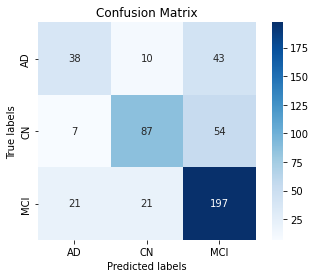

In [10]:
p2 = model05.predict(testing_image_datagen)
predicted_lab = p2.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save(f"{savepath}/xception_50_0.0001.h5",p2 ) 

In [12]:
savepath = 'Finetuning/Xception/Adam/Xception_50_0.0001/'
lr=0.000001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'xception_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.Adam(learning_rate=lr)
model05 = xception_row(OPT, LOOS,METRICS,image_Shape)
history05 = model05.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model05 = xception_row(OPT, LOOS,METRICS,image_Shape)
model05.load_weights(glob.glob(f"{savepath}xception_row_10E-5_weights-epoch:*-val_Accuracy:{max(history05.history['val_Accuracy']):.4f}.h5")[0])
model05.save(f"{savepath}/xception_50_0.000001.h5")
p2 = model05.predict(testing_image_datagen)
predicted_lab = p2.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save(f"{savepath}/xception_50_0.000001.h5",p2 )  

Epoch 1/50
476/476 [==============================] - 36s 71ms/step - loss: 11.4821 - Accuracy: 0.4460 - AD_Precision: 0.2000 - CN_Precision: 0.3132 - MCI_Precision: 0.5485 - AD_Recall: 0.1584 - CN_Recall: 0.2504 - MCI_Recall: 0.6388 - val_loss: 6.9559 - val_Accuracy: 0.4812 - val_AD_Precision: 0.2857 - val_CN_Precision: 0.3729 - val_MCI_Precision: 0.5227 - val_AD_Recall: 0.0220 - val_CN_Recall: 0.2973 - val_MCI_Recall: 0.7699
Epoch 2/50
476/476 [==============================] - 32s 68ms/step - loss: 9.0395 - Accuracy: 0.4603 - AD_Precision: 0.2212 - CN_Precision: 0.3391 - MCI_Precision: 0.5966 - AD_Recall: 0.2199 - CN_Recall: 0.3398 - MCI_Recall: 0.5949 - val_loss: 7.3134 - val_Accuracy: 0.5293 - val_AD_Precision: 0.5000 - val_CN_Precision: 0.5455 - val_MCI_Precision: 0.5278 - val_AD_Recall: 0.0549 - val_CN_Recall: 0.2027 - val_MCI_Recall: 0.9121
Epoch 3/50
476/476 [==============================] - 30s 63ms/step - loss: 8.3976 - Accuracy: 0.4887 - AD_Precision: 0.2194 - CN_Precision

NameError: name 'model04' is not defined

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


              precision    recall  f1-score   support

          AD       0.54      0.53      0.53        91
          CN       0.73      0.69      0.71       148
         MCI       0.75      0.78      0.77       239

    accuracy                           0.71       478
   macro avg       0.67      0.67      0.67       478
weighted avg       0.70      0.71      0.70       478



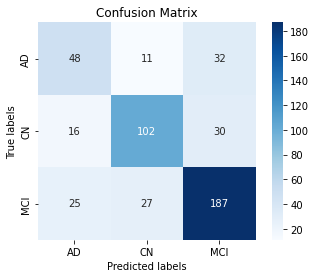

In [13]:
model05.save(f"{savepath}/xception_50_0.000001.h5")
p2 = model05.predict(testing_image_datagen)
predicted_lab = p2.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save(f"{savepath}/xception_50_0.000001.h5",p2 )

Epoch 1/50
476/476 [==============================] - 109s 223ms/step - loss: 78.1711 - Accuracy: 0.4830 - AD_Precision: 0.2634 - CN_Precision: 0.3908 - MCI_Precision: 0.5821 - AD_Recall: 0.2435 - CN_Recall: 0.3454 - MCI_Recall: 0.6303 - val_loss: 8.7956 - val_Accuracy: 0.3954 - val_AD_Precision: 0.2545 - val_CN_Precision: 0.4538 - val_MCI_Precision: 0.5854 - val_AD_Recall: 0.6154 - val_CN_Recall: 0.3986 - val_MCI_Recall: 0.3013
Epoch 2/50
476/476 [==============================] - 41s 85ms/step - loss: 20.8393 - Accuracy: 0.4961 - AD_Precision: 0.2967 - CN_Precision: 0.3828 - MCI_Precision: 0.6125 - AD_Recall: 0.3012 - CN_Recall: 0.3553 - MCI_Recall: 0.6224 - val_loss: 6.7944 - val_Accuracy: 0.3787 - val_AD_Precision: 0.2451 - val_CN_Precision: 0.3778 - val_MCI_Precision: 0.5145 - val_AD_Recall: 0.5495 - val_CN_Recall: 0.2297 - val_MCI_Recall: 0.3724
Epoch 3/50
476/476 [==============================] - 39s 81ms/step - loss: 17.7255 - Accuracy: 0.4855 - AD_Precision: 0.3240 - CN_Preci

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


              precision    recall  f1-score   support

          AD       0.61      0.36      0.46        91
          CN       0.59      0.61      0.60       148
         MCI       0.64      0.73      0.68       239

    accuracy                           0.62       478
   macro avg       0.62      0.57      0.58       478
weighted avg       0.62      0.62      0.62       478



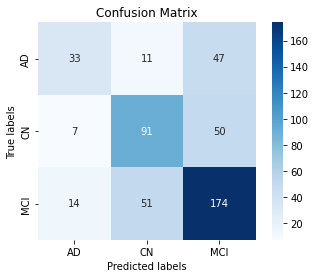

In [14]:
savepath = 'Finetuning/Xception/RMSprop/Xception_50_0.0001/'
lr=0.0001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'xception_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.Adam(learning_rate=lr)
model05 = xception_row(OPT, LOOS,METRICS,image_Shape)
history05 = model05.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model05 = xception_row(OPT, LOOS,METRICS,image_Shape)
model05.load_weights(glob.glob(f"{savepath}xception_row_10E-5_weights-epoch:*-val_Accuracy:{max(history05.history['val_Accuracy']):.4f}.h5")[0])
model05.save(f"{savepath}/xception_50_0.0001.h5")
p2 = model05.predict(testing_image_datagen)
predicted_lab = p2.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save(f"{savepath}/xception_50_0.0001.npy",p2 )  

Epoch 1/50


2024-03-20 20:29:38.774670: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


476/476 [==============================] - 163s 335ms/step - loss: 27.2694 - Accuracy: 0.4424 - AD_Precision: 0.2018 - CN_Precision: 0.3282 - MCI_Precision: 0.5783 - AD_Recall: 0.2078 - CN_Recall: 0.3301 - MCI_Recall: 0.5712 - val_loss: 19.3279 - val_Accuracy: 0.4958 - val_AD_Precision: 0.0000e+00 - val_CN_Precision: 0.4141 - val_MCI_Precision: 0.5928 - val_AD_Recall: 0.0000e+00 - val_CN_Recall: 0.7162 - val_MCI_Recall: 0.5481
Epoch 2/50
476/476 [==============================] - 127s 267ms/step - loss: 20.5025 - Accuracy: 0.4992 - AD_Precision: 0.2874 - CN_Precision: 0.4214 - MCI_Precision: 0.6042 - AD_Recall: 0.2892 - CN_Recall: 0.4214 - MCI_Recall: 0.6025 - val_loss: 8.2032 - val_Accuracy: 0.5209 - val_AD_Precision: 0.3611 - val_CN_Precision: 0.5054 - val_MCI_Precision: 0.6339 - val_AD_Recall: 0.4286 - val_CN_Recall: 0.6351 - val_MCI_Recall: 0.4854
Epoch 3/50
476/476 [==============================] - 127s 266ms/step - loss: 17.6700 - Accuracy: 0.5145 - AD_Precision: 0.3029 - CN_Pre

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


              precision    recall  f1-score   support

          AD       0.85      0.24      0.38        91
          CN       0.69      0.67      0.68       148
         MCI       0.67      0.86      0.75       239

    accuracy                           0.68       478
   macro avg       0.74      0.59      0.60       478
weighted avg       0.71      0.68      0.66       478



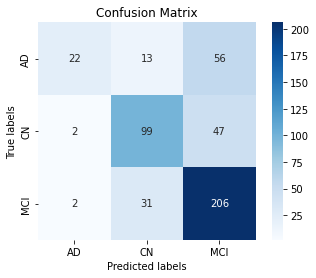

In [9]:
savepath = 'Finetuning/Xception/RMSprop/Xception_50_0.00001/'
lr=0.00001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'xception_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.RMSprop(learning_rate=lr)
model05 = xception_row(OPT, LOOS,METRICS,image_Shape)
history05 = model05.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model05 = xception_row(OPT, LOOS,METRICS,image_Shape)
model05.load_weights(glob.glob(f"{savepath}xception_row_10E-5_weights-epoch:*-val_Accuracy:{max(history05.history['val_Accuracy']):.4f}.h5")[0])
model05.save(f"{savepath}/xception_50_0.00001.h5")
p2 = model05.predict(testing_image_datagen)
predicted_lab = p2.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save(f"{savepath}/xception_50_0.00001.npy",p2 ) 

Epoch 1/50
476/476 [==============================] - 51s 103ms/step - loss: 10.4934 - Accuracy: 0.4624 - AD_Precision: 0.2476 - CN_Precision: 0.3807 - MCI_Precision: 0.5872 - AD_Recall: 0.2411 - CN_Recall: 0.4163 - MCI_Recall: 0.5545 - val_loss: 5.2168 - val_Accuracy: 0.5335 - val_AD_Precision: 0.2857 - val_CN_Precision: 0.6032 - val_MCI_Precision: 0.5270 - val_AD_Recall: 0.0220 - val_CN_Recall: 0.2568 - val_MCI_Recall: 0.8996
Epoch 2/50
476/476 [==============================] - 48s 100ms/step - loss: 8.8798 - Accuracy: 0.4619 - AD_Precision: 0.2303 - CN_Precision: 0.3592 - MCI_Precision: 0.5853 - AD_Recall: 0.2289 - CN_Recall: 0.3592 - MCI_Recall: 0.5825 - val_loss: 6.5955 - val_Accuracy: 0.5188 - val_AD_Precision: 0.2727 - val_CN_Precision: 0.7391 - val_MCI_Precision: 0.5135 - val_AD_Recall: 0.0330 - val_CN_Recall: 0.1149 - val_MCI_Recall: 0.9540
Epoch 3/50
476/476 [==============================] - 51s 106ms/step - loss: 8.1516 - Accuracy: 0.4740 - AD_Precision: 0.2418 - CN_Precis

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


              precision    recall  f1-score   support

          AD       0.62      0.32      0.42        91
          CN       0.72      0.60      0.65       148
         MCI       0.67      0.86      0.75       239

    accuracy                           0.68       478
   macro avg       0.67      0.59      0.61       478
weighted avg       0.67      0.68      0.66       478



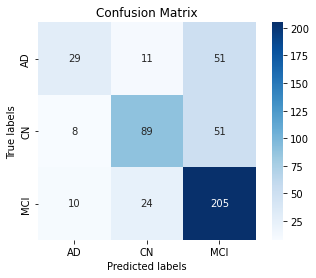

In [10]:
savepath = 'Finetuning/Xception/RMSprop/Xception_50_0.00001/'
lr=0.000001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'xception_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.RMSprop(learning_rate=lr)
model05 = xception_row(OPT, LOOS,METRICS,image_Shape)
history05 = model05.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model05 = xception_row(OPT, LOOS,METRICS,image_Shape)
model05.load_weights(glob.glob(f"{savepath}xception_row_10E-5_weights-epoch:*-val_Accuracy:{max(history05.history['val_Accuracy']):.4f}.h5")[0])
model05.save(f"{savepath}/xception_50_0.000001.h5")
p2 = model05.predict(testing_image_datagen)
predicted_lab = p2.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save(f"{savepath}/xception_50_0.000001.npy",p2 ) 

In [9]:
savepath = 'Finetuning/Xception/Xception_70_0.00001/'
lr=0.00001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'xception_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.Adam(learning_rate=lr)
model05 = xception_row(OPT, LOOS,METRICS,image_Shape)
history05 = model05.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model05 = xception_row(OPT, LOOS,METRICS,image_Shape)
model05.load_weights(glob.glob(f"{savepath}xception_row_10E-5_weights-epoch:*-val_Accuracy:{max(history05.history['val_Accuracy']):.4f}.h5")[0])
model04.save(f"{savepath}/xception_50_0.0001.h5")
p2 = model05.predict(testing_image_datagen)
predicted_lab = p2.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save(f"{savepath}/xception_50_0.0001.h5",p2 )  

Epoch 1/70


2024-04-14 23:13:43.463389: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


476/476 [==============================] - 43s 79ms/step - loss: 26.6594 - Accuracy: 0.4419 - AD_Precision: 0.2121 - CN_Precision: 0.3119 - MCI_Precision: 0.5767 - AD_Recall: 0.2108 - CN_Recall: 0.3107 - MCI_Recall: 0.5778 - val_loss: 16.6652 - val_Accuracy: 0.4351 - val_AD_Precision: 0.2727 - val_CN_Precision: 0.5172 - val_MCI_Precision: 0.6226 - val_AD_Recall: 0.6923 - val_CN_Recall: 0.3041 - val_MCI_Recall: 0.4142
Epoch 2/70
476/476 [==============================] - 34s 72ms/step - loss: 18.5493 - Accuracy: 0.5224 - AD_Precision: 0.3382 - CN_Precision: 0.4194 - MCI_Precision: 0.6341 - AD_Recall: 0.3464 - CN_Recall: 0.4194 - MCI_Recall: 0.6281 - val_loss: 13.0476 - val_Accuracy: 0.4686 - val_AD_Precision: 0.2865 - val_CN_Precision: 0.4733 - val_MCI_Precision: 0.6645 - val_AD_Recall: 0.5385 - val_CN_Recall: 0.4797 - val_MCI_Recall: 0.4310
Epoch 3/70
476/476 [==============================] - 34s 71ms/step - loss: 14.5135 - Accuracy: 0.5508 - AD_Precision: 0.3623 - CN_Precision: 0.457

NameError: name 'model04' is not defined

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


              precision    recall  f1-score   support

          AD       0.82      0.46      0.59        91
          CN       0.74      0.66      0.70       148
         MCI       0.71      0.87      0.78       239

    accuracy                           0.73       478
   macro avg       0.76      0.66      0.69       478
weighted avg       0.74      0.73      0.72       478



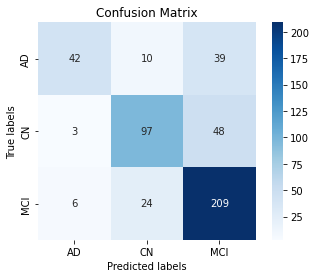

In [11]:
model05.save(f"{savepath}/xception_50_0.0001.h5")
p2 = model05.predict(testing_image_datagen)
predicted_lab = p2.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save(f"{savepath}/xception_50_0.0001.h5",p2 )    

Epoch 1/100
476/476 [==============================] - 38s 73ms/step - loss: 25.3046 - Accuracy: 0.4567 - AD_Precision: 0.2198 - CN_Precision: 0.3477 - MCI_Precision: 0.5893 - AD_Recall: 0.2278 - CN_Recall: 0.3446 - MCI_Recall: 0.5847 - val_loss: 22.7434 - val_Accuracy: 0.5335 - val_AD_Precision: 0.0000e+00 - val_CN_Precision: 0.7059 - val_MCI_Precision: 0.5203 - val_AD_Recall: 0.0000e+00 - val_CN_Recall: 0.1622 - val_MCI_Recall: 0.9665
Epoch 2/100
476/476 [==============================] - 31s 65ms/step - loss: 24.2316 - Accuracy: 0.5224 - AD_Precision: 0.3084 - CN_Precision: 0.4255 - MCI_Precision: 0.6364 - AD_Recall: 0.3102 - CN_Recall: 0.4214 - MCI_Recall: 0.6376 - val_loss: 14.5044 - val_Accuracy: 0.5251 - val_AD_Precision: 0.4286 - val_CN_Precision: 0.5690 - val_MCI_Precision: 0.5218 - val_AD_Recall: 0.0330 - val_CN_Recall: 0.2230 - val_MCI_Recall: 0.8996
Epoch 3/100
476/476 [==============================] - 31s 65ms/step - loss: 16.6002 - Accuracy: 0.5813 - AD_Precision: 0.4103

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


              precision    recall  f1-score   support

          AD       0.83      0.43      0.57        91
          CN       0.71      0.81      0.76       148
         MCI       0.75      0.82      0.79       239

    accuracy                           0.74       478
   macro avg       0.76      0.69      0.70       478
weighted avg       0.75      0.74      0.74       478



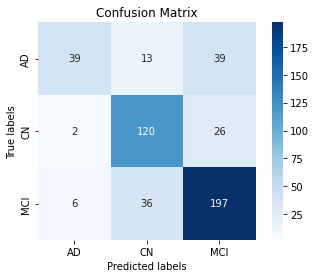

In [10]:
savepath = 'Finetuning/Xception/xception_100_0.00001/'
lr=0.00001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'xception_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.Adam(learning_rate=lr)
model05 = xception_row(OPT, LOOS,METRICS,image_Shape)
history05 = model05.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model05 = xception_row(OPT, LOOS,METRICS,image_Shape)
model05.load_weights(glob.glob(f"{savepath}xception_row_10E-5_weights-epoch:*-val_Accuracy:{max(history05.history['val_Accuracy']):.4f}.h5")[0])
model05.save(f"{savepath}/xception_50_0.0001.h5")
p2 = model05.predict(testing_image_datagen)
predicted_lab = p2.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save(f"{savepath}/xception_50_0.0001.h5",p2 )  